In [1]:
import sys
from operator import itemgetter
import _pickle as pkl
import random
import pandas
import numpy as np
# from sklearn.model_selection import *
# from sklearn.linear_model import *
# from sklearn.metrics import *
import tensorflow as tf
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib import learn
import gensim

/home/andylane/Envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
words = pkl.load(open("tf_data/training_data_names.pkl", "rb"))

X = pkl.load(open("tf_data/training_data_names_unstemmed.pkl", "rb"))
y = pkl.load(open("tf_data/training_labels_num.pkl", "rb"))

ground_truth_X = pkl.load(open("tf_data/test_data_names.pkl", "rb"))
ground_truth_y = pkl.load(open("tf_data/test_labels_num.pkl", "rb"))

In [15]:
import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2


In [3]:
# Notes to self:

## There are 300,000 words in the Google News model
len(model.vocab)

## Get words from given index
model.wv.index2word[2898]
# Out: 'judges"

## Find the odd word out:
model.doesnt_match(X[3].split())

## Access recipes:
print(X[3])
print(words[3])

## Get the similarity between two phrases. This is implemented in gensim as
## just the cosine similarity of the means of the two vectors
model.n_similarity(X[3].split(), X[7].split())
model.similarity("saucepan", "food")

## There's a case for n-gramming with underscores:
model.most_similar(["cinnamon", "roll"])
# Out e.g.: coconut_flakes, graham_cracker_crumbs
model.most_similar("cinnamon_roll")
# Out e.g.: cinnamon_rolls, oatmeal_cookie, peach_pie

Campfire Banana Splits
campfir banana split


[('cinnamon_rolls', 0.655969500541687),
 ('oatmeal_cookie', 0.62870192527771),
 ('peach_pie', 0.6216853260993958),
 ('banana_walnut', 0.6158987283706665),
 ('baked_beans_peaches', 0.6140761375427246),
 ('waffle_cone', 0.6071435809135437),
 ('fruit_cobbler', 0.6069991588592529),
 ('snickerdoodle', 0.6056694984436035),
 ('turtle_cheesecake', 0.6054642200469971),
 ('yogurt_parfait', 0.6052801609039307)]

In [4]:
# Remove words that are not in the Google News model
# TODO: Also remove stopwords - not necessary to average e.g. "in"
filtered_x = []
filtered_y = []
for index, recipe in enumerate(X):
    recipe_words = recipe.split()
    recipe_words = list(filter(lambda x: x in model.vocab, recipe_words))
    if len(recipe_words) > 0: #don't add empty lists - the LinReg can't fit NaNs
        filtered_x.append(recipe_words)
        filtered_y.append(y[index]) # to keep y_ same index
    else:
        None

In [5]:
filtered_x[571]

['Chicken', 'Kale', 'in', 'Parmesan', 'Cream', 'Sauce']

In [6]:
def input_preprocessor(dish, model=model):
    '''
    filter for words that are in the model and extract bigrams
    Usage: input_preprocessor(dish). Returns np.array of size model dimensions 
        (300 dimensions for GoogleNews Word2Vec model)
    dish: list of words in recipe title
    model: a word2vec model
    '''
    
    #dish = dish.split()
    
    ngrammed = []
    ngrammed.extend(dish)
    for index, word in enumerate(dish):
        if index+1 < len(dish):
            ngrammed.append(word + "_" + dish[index+1])
    # duplicate words won't help us
    ngrammed = set(ngrammed)
    # only include words that have a cosine similarity with the word "food" above a certain threshold
    # better idea: weight them against cosine similarity to food!
    foodywords = list(filter(lambda x: x in model.vocab and model.similarity(x, "food") > 0.16, ngrammed))
    # if no words are that close to food, pick the top two
    if len(foodywords) == 0:
        sims = []
        for x in ngrammed:
            if x in model.vocab:
                sims.append((x, model.similarity(x, "food")))
        foodywords = [word for word, similarity in sorted(sims, key=itemgetter(1))[:2]]
    foodywords = set(foodywords)
    #print(foodywords)
#     for term in dish:
#         print(term)
#         print(model.similarity(term, "food"))
#     return dish
    # Return the average of all the foody-word vectors in the recipe name
    return np.array([model[w] for w in foodywords]).mean(axis=0)

In [7]:
# Apply the input preprocessor across the filtered list of recipes
filtered_x_vect = []
for index, i in enumerate(filtered_x):
    filtered_x_vect.append(input_preprocessor(i, model))
filtered_x_vect = np.array(filtered_x_vect)

In [8]:
filtered_y = np.array([filtered_y]).transpose()

In [9]:
filtered_y = np.array(filtered_y)

In [10]:
# embedded_x = np.zeros((len(filtered_x), 300))
# for index, i in enumerate(filtered_x):
#     embedded_x[index] = model[filtered_x[index]]

In [11]:
import tflearn

In [12]:
print(filtered_x_vect.shape)
print(filtered_y.shape)

(3938, 300)
(3938, 1)


In [250]:
#tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)
tf.reset_default_graph()
tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
net = tflearn.fully_connected(net, 64, activation="linear", regularizer="L2", weight_decay=0.0005)
net = tflearn.dropout(net, 0.1)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 64, activation="linear", regularizer="L1", weight_decay=0.0005)

net = tflearn.fully_connected(net, 1, activation='linear') #Your final, output layer must have the same dimensions as the y input

net = tflearn.dropout(net, 0.5)
#net = tflearn.regression(net, optimizer="adam", learning_rate=0.01)
net = tflearn.regression(net, optimizer="sgd",loss="mean_square", metric="R2", learning_rate=0.001)
#net = tflearn.regression(net, optimizer=tflearn.optimizers.AdaGrad(learning_rate=0.001, initial_accumulator_value=0.01),loss="mean_square", metric="R2", learning_rate=0.001)

dnnmodel = tflearn.DNN(net)
dnnmodel.fit(filtered_x_vect, filtered_y, batch_size = 32, n_epoch = 100, show_metric=True)

Training Step: 12399  | total loss: 6608.24951 | time: 0.407s
| SGD | epoch: 100 | loss: 6608.24951 - R2: 0.4316 -- iter: 3936/3938
Training Step: 12400  | total loss: 6863.83496 | time: 0.411s
| SGD | epoch: 100 | loss: 6863.83496 - R2: 0.4173 -- iter: 3938/3938
--


In [251]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.22371178971003489

In [179]:
dnnmodel.save("linear_model.tf")

INFO:tensorflow:/home/andylane/menusights/menusights/linear_model.tf is not in all_model_checkpoint_paths. Manually adding it.


In [248]:
#tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)
tf.reset_default_graph()

tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
net = tflearn.fully_connected(net, 64, activation="linear", regularizer="L2", weight_decay=0.0005)
#net = tflearn.fully_connected(net, 64, activation="softmax", regularizer="L1", weight_decay=0.0005)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='linear') #Your final, output layer must have the same dimensions as the y input
net = tflearn.regression(net, optimizer="sgd",loss="mean_square", metric="R2", learning_rate=0.01)

dnnmodel = tflearn.DNN(net)
dnnmodel.fit(filtered_x_vect, filtered_y, batch_size = 32, n_epoch = 50, show_metric=True)

Training Step: 6199  | total loss: 3668.51514 | time: 0.332s
| SGD | epoch: 050 | loss: 3668.51514 - R2: 0.7652 -- iter: 3936/3938
Training Step: 6200  | total loss: 3471.63135 | time: 0.335s
| SGD | epoch: 050 | loss: 3471.63135 - R2: 0.8067 -- iter: 3938/3938
--


In [249]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.26711130938753103

In [202]:
dnnmodel.save("linear_model_08.tf")

INFO:tensorflow:/home/andylane/menusights/menusights/linear_model_08.tf is not in all_model_checkpoint_paths. Manually adding it.


In [244]:
#tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)
tf.reset_default_graph()

tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
net = tflearn.fully_connected(net, 10, activation="linear", regularizer="L1", weight_decay=0.0005)
#net = tflearn.fully_connected(net, 64, activation="softmax", regularizer="L1", weight_decay=0.0005)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='linear') #Your final, output layer must have the same dimensions as the y input
net = tflearn.regression(net, optimizer="sgd",loss="mean_square", metric="R2", learning_rate=0.01)

dnnmodel = tflearn.DNN(net)
dnnmodel.fit(filtered_x_vect, filtered_y, batch_size = 32, n_epoch = 50, show_metric=True)

Training Step: 6199  | total loss: 3721.29565 | time: 0.606s
| SGD | epoch: 050 | loss: 3721.29565 - R2: 0.7820 -- iter: 3936/3938
Training Step: 6200  | total loss: 3721.29565 | time: 0.609s
| SGD | epoch: 050 | loss: 3721.29565 - R2: 0.7820 -- iter: 3938/3938
--


In [245]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.26652300504059528

In [23]:
#tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)
tf.reset_default_graph()

tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
net = tflearn.fully_connected(net, 10, activation="linear", regularizer="L1", weight_decay=0.0005)
net = tflearn.fully_connected(net, 10, activation="linear", regularizer="L2", weight_decay=0.0005)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='linear') #Your final, output layer must have the same dimensions as the y input
net = tflearn.regression(net, optimizer="sgd",loss="mean_square", metric="R2", learning_rate=0.01)

dnnmodel = tflearn.DNN(net)
dnnmodel.fit(filtered_x_vect, filtered_y, batch_size = 32, n_epoch = 100, show_metric=True)

Training Step: 12399  | total loss: 11657.25195 | time: 0.420s
| SGD | epoch: 100 | loss: 11657.25195 - R2: 0.0258 -- iter: 3936/3938
Training Step: 12400  | total loss: 11104.76660 | time: 0.425s
| SGD | epoch: 100 | loss: 11104.76660 - R2: 0.0268 -- iter: 3938/3938
--


In [243]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.31486165628695023

In [37]:
#tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5)
tf.reset_default_graph()

tflearn.init_graph()

net = tflearn.input_data(shape=[None, 300])
net = tflearn.fully_connected(net, 10, activation="softmax", regularizer="L1", weight_decay=0.0005)
net = tflearn.fully_connected(net, 10, activation="tanh", regularizer="L2", weight_decay=0.0005)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 10, activation="relu", regularizer="L1", weight_decay=0.0005)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 10, activation="relu", regularizer="L1", weight_decay=0.0005)
net = tflearn.fully_connected(net, 1, activation='linear') #Your final, output layer must have the same dimensions as the y input
net = tflearn.regression(net, optimizer="adam",loss="mean_square", metric="R2", learning_rate=0.001)

dnnmodel = tflearn.DNN(net, tensorboard_verbose=3, tensorboard_dir="graph")
dnnmodel.fit(filtered_x_vect, filtered_y, batch_size = 32, n_epoch = 1000, show_metric=True)
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

Training Step: 123999  | total loss: 2195.90137 | time: 0.675s
| Adam | epoch: 1000 | loss: 2195.90137 - R2: 0.9388 -- iter: 3936/3938
Training Step: 124000  | total loss: 2232.30273 | time: 0.681s
| Adam | epoch: 1000 | loss: 2232.30273 - R2: 0.9037 -- iter: 3938/3938
--


0.6237392085441702

In [40]:
# More training
dnnmodel.fit(filtered_x_vect, filtered_y, batch_size = 32, n_epoch = 1000, show_metric=True)

Training Step: 247999  | total loss: 1671.23584 | time: 0.594s
| Adam | epoch: 2000 | loss: 1671.23584 - R2: 0.8751 -- iter: 3936/3938
Training Step: 248000  | total loss: 1518.20239 | time: 0.599s
| Adam | epoch: 2000 | loss: 1518.20239 - R2: 0.8941 -- iter: 3938/3938
--


In [41]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.67182523166785491

In [16]:
# for best all relu and linear
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.3555411622618414

In [43]:
#sgd 10 layers with relu
list(zip(dnnmodel.predict(filtered_x_vect[50:60]), filtered_y[50:60]))

[(array([ 35.10609818], dtype=float32), array([36])),
 (array([ 34.24204636], dtype=float32), array([13])),
 (array([ 38.24633408], dtype=float32), array([59])),
 (array([ 118.52932739], dtype=float32), array([193])),
 (array([ 47.22659683], dtype=float32), array([0])),
 (array([ 33.21518707], dtype=float32), array([40])),
 (array([ 177.88861084], dtype=float32), array([394])),
 (array([ 79.42707825], dtype=float32), array([159])),
 (array([ 89.48239899], dtype=float32), array([69])),
 (array([ 65.68340302], dtype=float32), array([38]))]

In [17]:
#sgd
list(zip(dnnmodel.predict(filtered_x_vect[50:60]), filtered_y[50:60]))

[(array([ 49.70022583], dtype=float32), array([36])),
 (array([ 49.6131134], dtype=float32), array([13])),
 (array([ 56.98905563], dtype=float32), array([59])),
 (array([ 173.17416382], dtype=float32), array([193])),
 (array([ 51.9260025], dtype=float32), array([0])),
 (array([ 64.88386536], dtype=float32), array([40])),
 (array([ 47.79671097], dtype=float32), array([394])),
 (array([ 128.43122864], dtype=float32), array([159])),
 (array([ 96.40604401], dtype=float32), array([69])),
 (array([ 56.64452744], dtype=float32), array([38]))]

In [44]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.67182523166785491

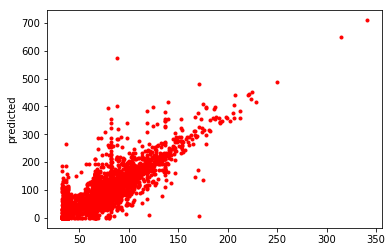

In [42]:
import matplotlib.pyplot as plt
plt.plot([i[0] for i in dnnmodel.predict(filtered_x_vect)], filtered_y, 'r.')
plt.ylabel('predicted')
plt.show()

In [46]:
ground_truth_X

['Outback Sirloin, 9 Oz SIGNATURE STEAKS - Outback Special 9 oz',
 'Outback Sirloin, 6 Oz SIGNATURE STEAKS - Outback Special 6 oz',
 'Outback Flat Iron ',
 'Outback Calzone Calzones - Outback Calzone',
 'Outback Sirloin, 12 Oz SIGNATURE STEAKS - Outback Special 12 oz',
 'Outback Pizza, Personal Baked Personal Pizzas - outback',
 'Outback Pizza, Medium MEDIUM PIZZAS - outback',
 'Outback Pizza, Large LARGE PIZZAS - outback',
 'House Salad FRESHLY MADE SIDES - House Salad',
 'Sesame Salad ',
 'Outback Pizza, Family FAMILY PIZZAS - outback',
 'The Outbacker Burger Without Cheese BURGERS & SANDWICHES - The Outbacker Burger',
 "Bloomin' Onion AUSSIE-TIZERS TO SHARE - Bloomin' Onion&reg;",
 'Firecracker Salmon ',
 'Pork Porterhouse ',
 'Double Burger BURGERS & SANDWICHES - Double Burger',
 'Ribeye Melt ',
 'Aussie Fries FRESHLY MADE SIDES - Aussie Fries',
 'Caesar Salad FRESHLY MADE SIDES - Caesar Salad',
 'Garlic Mashed Potatoes FRESHLY MADE SIDES - Garlic Mashed Potatoes',
 "The Bloomin' B

In [50]:
# Remove words that are not in the Google News model
# TODO: Also remove stopwords - not necessary to average e.g. "in"
filtered_x = []
filtered_y = []
for index, recipe in enumerate(ground_truth_X):
    recipe_words = recipe.split()
    recipe_words = list(filter(lambda x: x in model.vocab, recipe_words))
    if len(recipe_words) > 0: #don't add empty lists - the LinReg can't fit NaNs
        filtered_x.append(recipe_words)
        filtered_y.append(ground_truth_y[index]) # to keep y_ same index
    else:
        None

In [51]:
# Apply the input preprocessor across the filtered list of recipes
filtered_x_vect = []
for index, i in enumerate(filtered_x):
    filtered_x_vect.append(input_preprocessor(i, model))
filtered_x_vect = np.array(filtered_x_vect)

In [52]:
filtered_y = np.array([filtered_y]).transpose()

In [9]:
#filtered_y = np.array(filtered_y)

In [53]:
print(filtered_x_vect.shape)
print(filtered_y.shape)

(307, 300)
(307, 1)


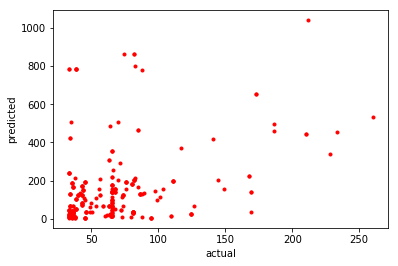

In [153]:
import matplotlib.pyplot as plt
plt.plot([i[0] for i in dnnmodel.predict(filtered_x_vect)], filtered_y, 'r.')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()

In [55]:
rsquared([i[0] for i in dnnmodel.predict(filtered_x_vect)], [i[0] for i in filtered_y])

0.11763143463865514

## **Comparison to a simple linear regression**

In [66]:
import sklearn
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [134]:
linregX = pkl.load(open("tf_data/training_data_names.pkl", "rb"))
linregy = pkl.load(open("tf_data/training_labels_num.pkl", "rb"))

In [156]:
# One-hot encode vocab
vectorizer = CountVectorizer(linregX, ngram_range=(1,2))
lrX = vectorizer.fit_transform(linregX)
# Fit a model
linreg = linear_model.BayesianRidge()
linreg.fit(X=lrX.toarray(), y=y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [157]:
# How well does model predict training data
rsquared(linreg.predict(lrX), linregy)

0.72422744210735945

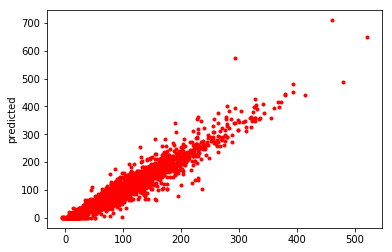

In [150]:
# How well does model predict training data?
import matplotlib.pyplot as plt
plt.plot(linreg.predict(lrX), linregy, 'r.')
plt.ylabel('predicted')
plt.show()

In [151]:
# How well does the model predict test data?
gtlinregx = pkl.load(open("tf_data/test_data_names.pkl", "rb"))
gtlinregy = pkl.load(open("tf_data/test_labels_num.pkl", "rb"))
gtlinregxtf = vectorizer.transform(gtlinregx)
print(rsquared(linreg.predict(gtlinregxtf), gtlinregy))

0.0462758895435


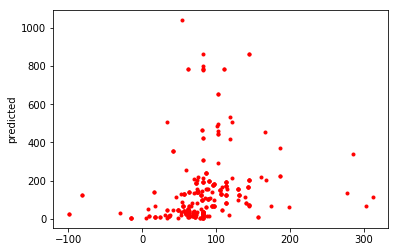

In [152]:
# How well does model predict test data (plot)?
import matplotlib.pyplot as plt
plt.plot(linreg.predict(gtlinregxtf), gtlinregy, 'r.')
plt.ylabel('predicted')
plt.show()